# Module: calibration

This module contains functions for calibration of 4DSTEM data, including calibrating pixel sizes, calibrating the rotational offset between the real and diffraction planes, correcting diffraction shifts, and correcting elliptical distortions.

### Correct ellitical distortions, with a beam stop

This notebook demos measuring and correction elliptical distortion of the diffraction patterns due to imperfect electron optics.  This notebook requires that the Bragg peaks and Bragg vector map have already been measured, and if necessary, the diffraction shifts corrected.

### Import packages, load data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import h5py
import py4DSTEM
import scipy.optimize as sciopt
from py4DSTEM.process.utils import print_progress_bar
from scipy.signal import convolve2d

from py4DSTEM.process.utils import polar_elliptical_transform

In [2]:
# Get data and masks

fp = "/home/lerandc/Downloads/data_polar_test.mat"
#fp = "/media/lerandc/DATA/files/Amorphous_simulations/Ta_sim_sa_051.h5"
#browser = py4DSTEM.file.io.FileBrowser(fp)
#browser.show_dataobjects()

#datacube = browser.get_dataobject('CBED_array_depth0002')
#print(datacube.data.shape)
f = h5py.File(fp)
mask160 = (np.array(f['sFEM']['mask']))
#mask300 = np.array(f['sFEM_300/mask'])
#mask600 = np.array(f['sFEM_600/mask'])
CBEDmean160 = (np.array(f['sFEM']['CBEDmean']))
var_ref = np.array(f['sFEM']['polarCBEDvar'])
mean_ref = np.array(f['sFEM']['polarCBEDmean'])
mask_ref = np.array(f['sFEM']['polarMask'])
full_mask = np.array(f['sFEM']['maskFull'])
#CBEDmean300 = np.array(f['CBEDmean_300'])
#CBEDmean600 = np.array(f['CBEDmean_600'])
f.close()

In [3]:
offset = 1 #pixels
cubeShape = datacube.data.shape
#datacube.data *= 5e5
yy,xx = np.meshgrid(np.arange(cubeShape[2]),np.arange(cubeShape[3]))
yy = yy - cubeShape[2]//2
xx = xx - cubeShape[3]//2
rr = np.sqrt(xx**2+yy**2)
mask = rr > 35
fit_mask = np.logical_and(rr> 50, rr < 175)
CBEDmean = np.mean(datacube.data,axis=(0,1))
fig,(ax11,ax12) = plt.subplots(1,2,figsize=(12,12))
ax11.imshow(mask*datacube.data[0,0,:,:]**0.4)
ax12.imshow(mask*CBEDmean**0.4)

NameError: name 'datacube' is not defined

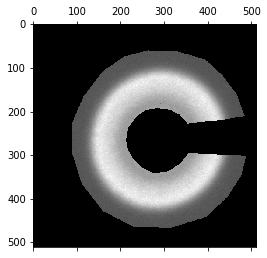

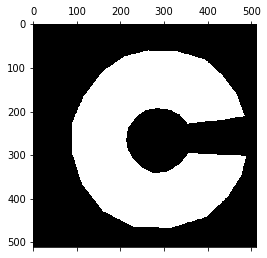

In [3]:
ar = CBEDmean160
mask = mask160
# print(np.max(datacube.data),np.mean(datacube.data),np.min(datacube.data))
plt.matshow(mask*ar)
plt.matshow(mask)

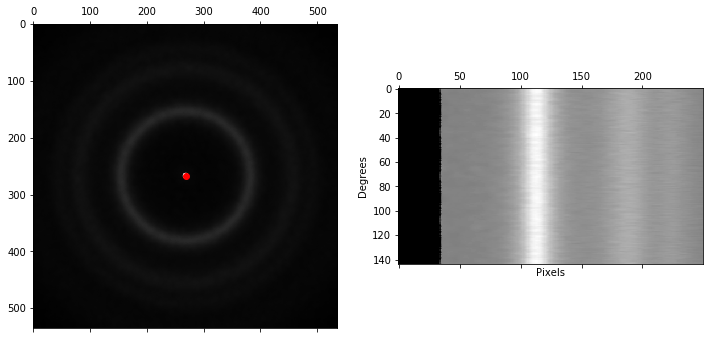

In [5]:
# Get initial polar transform
### Params ###
x0_init=None
y0_init=None
dr= 1             # in pixels
dtheta= 2.5       # in degrees
r_range=250      # either [min,max] or just max --> [0,max]
##############

# Perform transform
pet = polar_elliptical_transform(calibration_image=ar,
                                 mask=mask,
                                 x0_init=x0_init,
                                 y0_init=y0_init,
                                 dr=dr,
                                 dtheta=dtheta,
                                 r_range=r_range)
transform_mask = rr > 35
pet.get_polar_transform(mask=transform_mask)

# Show
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.matshow(pet.calibration_image**0.2)
ax1.scatter(pet.coefs[1],pet.coefs[0],color='r')
ax2.matshow(pet.polar_mask*pet.polar_ar**0.2)
ax2.set_xlabel('Pixels')
ax2.set_ylabel('Degrees')
plt.show()

Analyzing: |**************************************************| 100.0% Complete


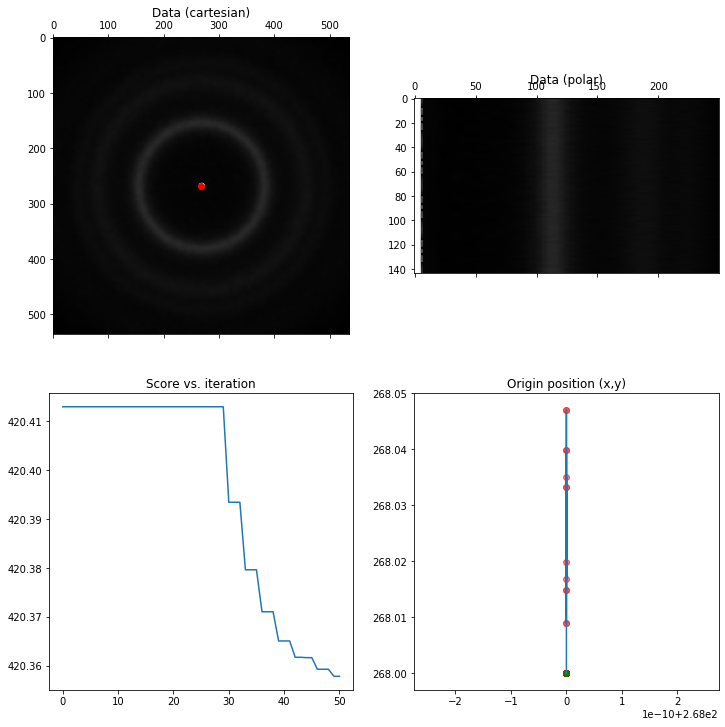

In [6]:
# Fit center

#### Params ####
n_iter=50
step_sizes_init = [1, 1]    # Initial step sizes [dx,dy] for the origin
step_scale=0.9              # If no step is taken, reduce step sizes by this fraction
################

# Perform fit
scores,x_vals,y_vals = pet.fit_origin(n_iter=n_iter,
                                      step_sizes_init=step_sizes_init,
                                      step_scale=step_scale,
                                      return_ans=True)

# Show
fig,((ax11,ax12),(ax21,ax22)) = plt.subplots(2,2,figsize=(12,12))
ax11.matshow(pet.calibration_image**0.2)
ax11.scatter(pet.coefs[1],pet.coefs[0],color='r')
ax12.matshow(pet.polar_ar**0.2)
ax21.plot(np.arange(len(scores)),scores)
ax22.plot(y_vals,x_vals)
ax22.scatter(y_vals,x_vals,color='r',alpha=0.3)
ax22.scatter(y_vals[0],x_vals[1],color='g')
ax11.set_title('Data (cartesian)')
ax12.set_title('Data (polar)')
ax21.set_title('Score vs. iteration')
ax22.set_title('Origin position (x,y)')
plt.show()

Analyzing: |**************************************************| 100.0% Complete


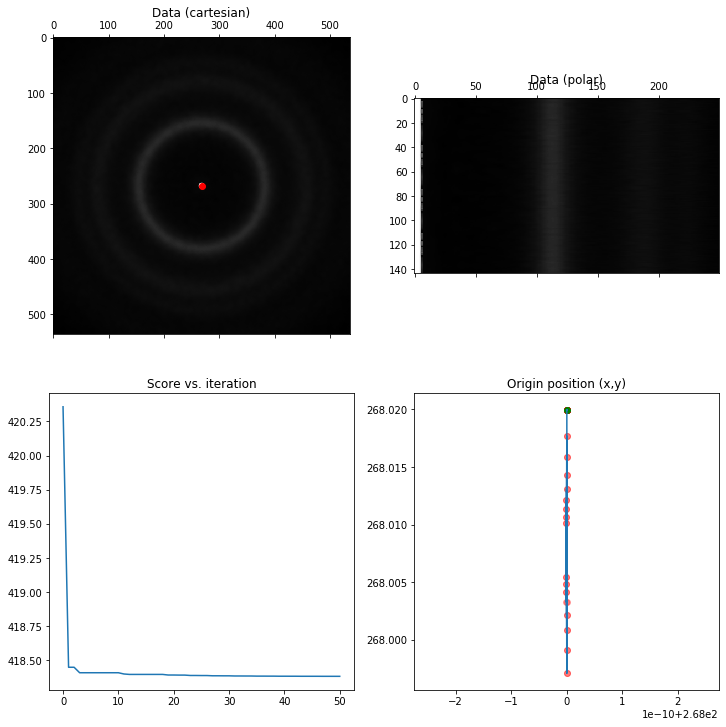

In [7]:
# Fit center

#### Params ####
n_iter=50
step_sizes_init = [0.1, 0.1, 0, 0.1, 0.1]    # Initial step sizes for [x0,y0,A,B,C] 
step_scale=0.9                               # If no step is taken, reduce step sizes by this fraction
################

# Perform fit
scores,x_vals,y_vals,A_vals,B_vals,C_vals = pet.fit_params(n_iter=n_iter,
                                                           step_sizes_init=step_sizes_init,
                                                           step_scale=step_scale,
                                                           return_ans=True)

# Show
fig,((ax11,ax12),(ax21,ax22)) = plt.subplots(2,2,figsize=(12,12))
ax11.matshow(pet.calibration_image**0.2)
ax11.scatter(pet.coefs[1],pet.coefs[0],color='r')
ax12.matshow(pet.polar_ar**0.2)
ax21.plot(np.arange(len(scores)),scores)
ax22.plot(y_vals,x_vals)
ax22.scatter(y_vals,x_vals,color='r',alpha=0.3)
ax22.scatter(y_vals[0],x_vals[1],color='g')
ax11.set_title('Data (cartesian)')
ax12.set_title('Data (polar)')
ax21.set_title('Score vs. iteration')
ax22.set_title('Origin position (x,y)')
plt.show()

In [8]:
def addPoissonNoise(orig,scale):
    #applies poisson noise after first scaling image array from [0,x] to [0,scale]
    #orig is noiseless image matrix, scale is scaling factor to assign discrete probablities of electron counts
    #returns noisy image array
    if scale > 0.0:
        scale /= np.max(orig)
        orig = orig * scale
        noisy = np.random.poisson(orig)
        return noisy
    return orig

In [14]:
#polar CBED mean is the calibration image currently
polarCBED_var = np.zeros(pet.polar_ar.shape)
polarCBEDmean = pet.polar_ar
CBED_stack = np.reshape(datacube.data,(cubeShape[0]*cubeShape[1],cubeShape[2],cubeShape[3]))
CBED_stack_noisy = np.copy(CBED_stack)


#apply poisson noise?
scale = 1500
for i in range(CBED_stack_noisy.shape[0]):
    CBED_stack_noisy[i,:,:] = addPoissonNoise(transform_mask*CBED_stack[i,:,:],scale)
    
CBEDmean_noisy = np.mean(CBED_stack_noisy,axis=0)
polarCBEDmean_noisy, __ = pet.get_polar_transform(ar=CBEDmean_noisy,mask=transform_mask,return_ans=True)
for i in range(CBED_stack.shape[0]):
    tmp_ar, _ = pet.get_polar_transform(ar=(CBED_stack_noisy[i,:,:]),mask=transform_mask,return_ans = True)
    polarCBED_var = polarCBED_var + (tmp_ar - polarCBEDmean_noisy)**2
    
polarCBED_var = polarCBED_var / CBED_stack.shape[0]

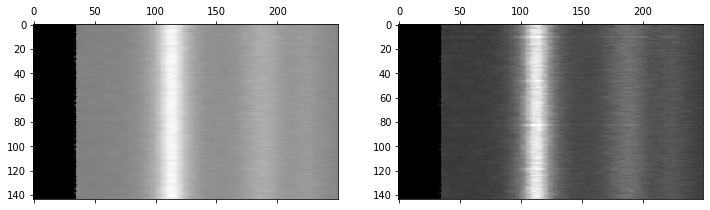

In [15]:
fig,(ax11,ax12) = plt.subplots(1,2,figsize=(12,12))
ax11.matshow(pet.polar_mask*polarCBEDmean_noisy**0.2)
ax12.matshow(pet.polar_mask*polarCBED_var**0.2)

In [16]:
print("Ellipticity is {}%".format(100*(max(pet.coefs[2],pet.coefs[3])/min(pet.coefs[2],pet.coefs[3]) - 1)))

Ellipticity is 2.220446049250313e-13%


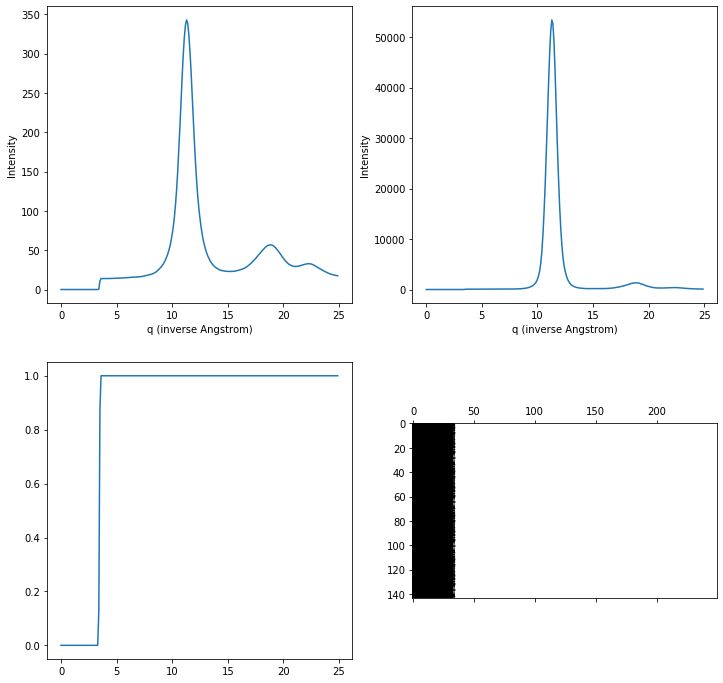

In [22]:
polarCBED_var.shape
yMean = np.mean(pet.polar_mask*polarCBEDmean_noisy,axis=0)
yVar = np.mean(pet.polar_mask*polarCBED_var,axis=0)
yNorm = np.mean(pet.polar_mask,axis=0)
pixelSize = 0.099927566964286


fig1,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12,12))
ax1.plot(np.arange(yMean.shape[0])*pixelSize, yMean)
ax1.set_xlabel('q (inverse Angstrom)')
ax1.set_ylabel('Intensity')
ax2.plot(np.arange(yMean.shape[0])*pixelSize, yVar)
ax2.set_xlabel('q (inverse Angstrom)')
ax2.set_ylabel('Intensity')
ax3.plot(np.arange(yMean.shape[0])*pixelSize, yNorm)
ax4.matshow(pet.polar_mask)

#print(mask_ar.shape)
#plt.matshow(full_mask)
sub = yNorm > 1e-1
yMean[sub] = yMean[sub] / yNorm[sub]
yVar[sub] = yVar[sub] / yNorm[sub]
yVar[np.logical_not(sub)] = 0

yy = yVar

sub = yMean > 0


yy[sub] = yVar[sub] / (yMean[sub]**2)


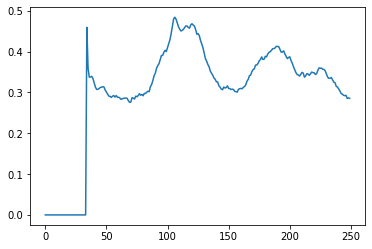

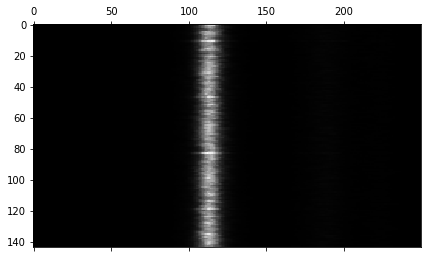

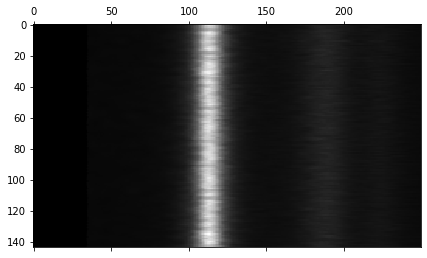

In [18]:
plt.plot(yy)
plt.matshow(polarCBED_var)
plt.matshow(polarCBEDmean_noisy)

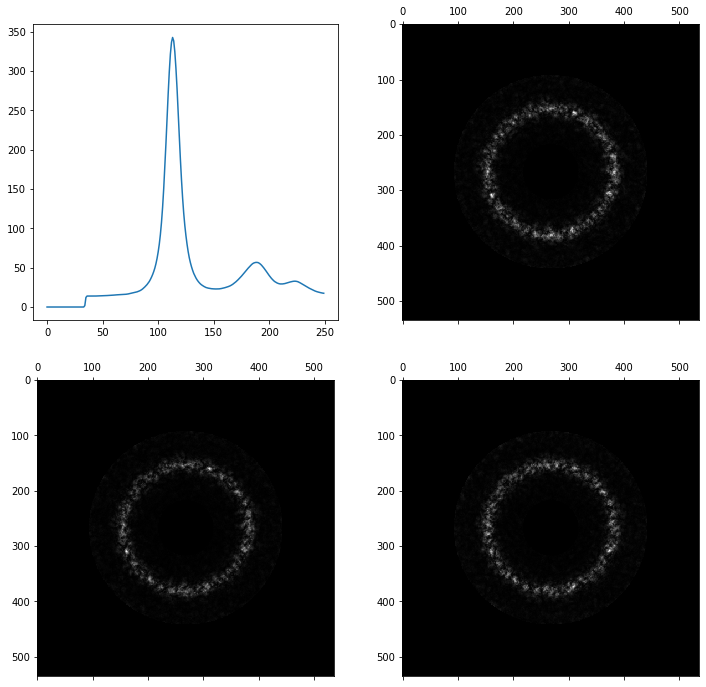

In [20]:
fig, ((ax11,ax12),(ax21,ax22)) = plt.subplots(2,2,figsize=(12,12))
tmp, _ = pet.get_polar_transform(CBEDmean_noisy,mask=transform_mask,return_ans=True)
ax11.plot(np.mean(tmp,axis=0))
ax12.matshow(mask*CBED_stack_noisy[1,:,:])
ax21.matshow(mask*CBED_stack_noisy[2,:,:])
ax22.matshow(mask*CBED_stack_noisy[3,:,:])

In [53]:
a = np.asarray([[1,2],[3,4]])
a[:,0]
mask_bool = pet.mask.astype(dtype=bool)
a= np.asarray([pet.xx[pet.mask.astype(dtype=bool)],pet.yy[pet.mask.astype(dtype=bool)]])
a.shape


(2, 88344)

5713.105097464716


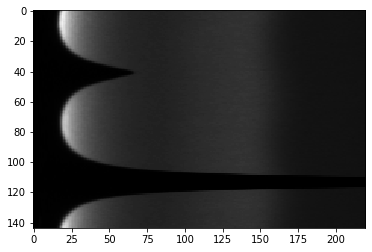

In [23]:
plt.imshow(polarCBEDmean,vmin=0,vmax=6000)

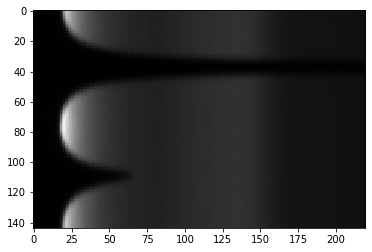

In [24]:
plt.imshow(polarCBEDmean_copy,vmin=0,vmax=6000)

### Relevant Mathematics

The discussion below includes the formalism for:

- the elliptical fitting routine
- conversion between the two representations of ellipses used here
- derivation of the transformation used to correct the measured elliptical distortions

#### Fitting ellipses

The representation of an ellipse we'll use for fitting purposes is

\begin{equation}
A(x-x_0)^2 + B(x-x_0)(y-y_0) + C(y-y0)^2 = 1
\end{equation}

The coordinates are $x$, $y$, and we will fit the five parameters $p = (x_0, y_0, A, B, C)$.  For some datapoint with intensity $I$ at $x_d$, $y_d$, we associate an error with respect to parameters $p$ given by $E(x_d,y_d,I; p) = I\cdot(A(x_d-x_0)^2 + B(x_d-x_0)(y_d-y_0) + C(y_d-y0)^2 - 1)$.  We find the best fit ellipse by finding

\begin{equation}
\underset{p}{\mathrm{argmin}} \sum_i E(x_i,y_i,I_i; p)^2
\end{equation}

where the sum runs over all datapoints $(x_i,y_i,I_i)$.

#### Converting representations

The parameters $x_0, y_0$ are the ellipse center; the parameters $A, B, C$ are related to the semiaxes and rotation.  Here, we briefly show that we can extract the semiaxes $a,b$ and rotation $\theta$ via:

\begin{equation}
\begin{matrix}
a^2    &=& \frac{2}{A+(A-C)\left(1+(\frac{B}{A-C})^2\right)+C}       \\
b^2    &=& \frac{2}{A-(A-C)\left(1+(\frac{B}{A-C})^2\right)+C}       \\
\theta &=& \frac{1}{2}\tan^{-1}\left(\frac{B}{A-C}\right)
\end{matrix}
\end{equation}

To derive these conversions, we begin from the representation of an ellipse

\begin{equation}
\frac{x'^2}{a^2} + \frac{y'^2}{b^2} = 1
\end{equation}

where $a$ and $b$ are the semiaxes, oriented along the $x'$ and $y'$ axes, respectively.  Now let $(x',y')$ be rotated counterclockwise by $\theta$ with respect to a coordinate system $(x,y)$.  Then

\begin{equation}
\begin{pmatrix}
x' \\
y'
\end{pmatrix}
=
\begin{pmatrix}
\cos\theta   &  \sin\theta  \\
-\sin\theta  &  \cos\theta
\end{pmatrix}
\begin{pmatrix}
x \\
y
\end{pmatrix}
\end{equation}

and the ellipse is

\begin{equation}
\frac{(x\cos\theta + y\sin\theta)^2}{a^2} + \frac{(-y\sin\theta + x\cos\theta)^2}{b^2} = 1
\end{equation}

which is equivalent to the ellipse from the prior section, where

\begin{equation}
\begin{matrix}
A &=& \frac{\cos^2\theta}{a^2} + \frac{\sin^2\theta}{b^2}        \\
B &=& 2\sin\theta\cos\theta\left(\frac{-a^2+b^2}{a^2b^2}\right)  \\
C &=& \frac{\sin^2\theta}{a^2} + \frac{\cos^2\theta}{b^2}
\end{matrix}
\end{equation}

The task at hand is to solve these three equations for $a, b, \theta$.

From the second equation, using $2\sin\theta\cos\theta = \sin2\theta$ we find $\frac{B}{\sin2\theta} = \frac{1}{a^2} - \frac{1}{b^2}$.

Subtracting the first and third equations and using $\cos^2\theta - \sin^2\theta = \cos2\theta$, we find $\frac{A-C}{\cos2\theta} = \frac{1}{a^2} - \frac{1}{b^2}$.

Setting these two results equal to one another, we find $\theta = \frac{1}{2}\tan^{-1}\left(\frac{B}{A-C}\right)$.

Adding the first and third equations gives $A+C=\frac{1}{a^2}+\frac{1}{b^2}$, and combining this with $\frac{B}{\sin2\theta}  =\frac{1}{a^2} - \frac{1}{b^2}$ by adding and subtracting gives, respectively:

\begin{equation}
a^2 = \frac{2}{A+\frac{B}{\sin2\theta}+C}        \\
b^2 = \frac{2}{A-\frac{B}{\sin2\theta}+C} 
\end{equation}

Recalling that $\sin(\tan^{-1}(\alpha)) = \frac{\alpha}{\sqrt{1+\alpha^2}}$, we substitute our expression for $\theta$ into $\sin2\theta$ and find $\frac{B}{\sin2\theta} = (A-C)\left(1+(\frac{B}{A-C})^2\right)^\frac{1}{2}$.  Substituting into the expressions above for $a^2$ and $b^2$ completes the derivation.

#### Transforming ellipses to circles

To correct any measured elliptical distortion, we apply an affine linear transformation of the form

\begin{equation}
T = 
\begin{pmatrix}
T_{11}   &   T_{12}   \\
T_{21}   &   T_{22}
\end{pmatrix}
\end{equation}

Geometrically, if we think of the ellipse as the conic section resulting from a plane intersecting a cone, we want a transformation which tilts the plane until it is perpendicular with the cone's axis.  Here, we use the transformation which compresses the ellipse the major axis until it is the same size as the minor axis.

For ellipse parameters $a$, $b$, $\theta$, assume without loss of generality that $a>b$.  We want a transformation which compresses by a factor of $s = \frac{b}{a}$.  If $\theta = 0$, then

\begin{equation}
T_0 = 
\begin{pmatrix}
s   &   0   \\
0   &   1
\end{pmatrix}
\end{equation}

For finite $\theta$, we simply rotate this transformation matrix, using the usual rotation matrix $R$:

\begin{align}
T &= R^{-1}T_0R \\
  &=
\begin{pmatrix}
    \cos\theta   &   -\sin\theta   \\
    \sin\theta   &   \cos\theta
\end{pmatrix}
\begin{pmatrix}
    s   &   0   \\
    0   &   1
\end{pmatrix}
\begin{pmatrix}
     \cos\theta   &   \sin\theta   \\
    -\sin\theta   &   \cos\theta
\end{pmatrix}  \\
 &=
\begin{pmatrix}
    \sin^2\theta + s\cdot\cos^2\theta     &    \sin\theta\cos\theta(s-1)          \\
    \sin\theta\cos\theta(s-1)             &    s\cdot\sin^2\theta + \cos^2\theta
\end{pmatrix}
\end{align}

For an original datapoint $(x,y)$, if we neglect translation of the center of coordinates here for simplicity, the  corresponding elliptical distortion corrected datapoint $(x',y')$ will be

\begin{equation}
\begin{pmatrix}
x' \\
y'
\end{pmatrix}
=
T
\begin{pmatrix}
x \\
y
\end{pmatrix}
\end{equation}

[4.31133124e+02 8.50688947e+03 2.62545649e+01 7.32510664e+02
 4.29474616e+01 1.44026723e+01 2.66375252e+02 2.87008174e+02
 7.27497234e-02 1.04809746e+00 1.40516797e+02]


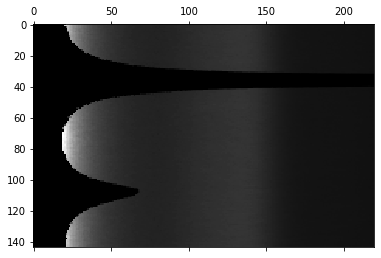

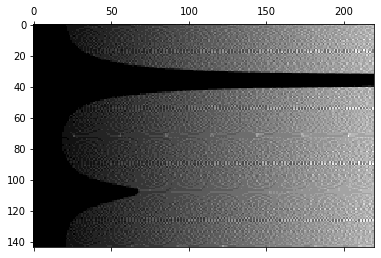

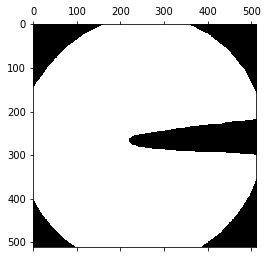

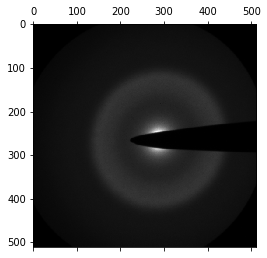

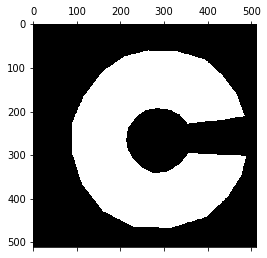

In [5]:
### Params ###
x0_init=None
y0_init=None
dr=1             # in pixels
dtheta=2.5      # in degrees
r_range=220     # either [min,max] or just max --> [0,max]
##############

# Perform transform
pet2 = polar_elliptical_transform(calibration_image=ar,
                                 mask=mask,
                                 x0_init=x0_init,
                                 y0_init=y0_init,
                                 dr=dr,
                                 dtheta=dtheta,
                                 r_range=r_range)

# init_coef = np.array([100,1000,30,])
pet2.fit_params_twoSided_gaussian()
print(pet2.coef_opt)
pet2.get_polar_transform_twoSided_gaussian(ar=ar,mask=full_mask)
plt.matshow(pet2.polar_ar)
plt.matshow(pet2.polar_mask)
plt.matshow(full_mask)
# polarCBEDmean_copy = np.copy(polarCBEDmean)
plt.matshow(ar)
plt.matshow(mask)

In [5]:
#inspect_ar = np.roll(pet.polar_ar,35,axis=0)
#np.mean(inspect_ar)
#Loading stack of cbeds
f2 = h5py.File('/home/lerandc/Downloads/Ellis_FEM_data_tilt_00.mat')
CBED_stack = np.array(f2['stack'])
f2.close()

In [6]:
polarCBEDmean.shape

(144, 220)

In [7]:
# fig,((ax11,ax12)) = plt.subplots(1,2,figsize=(12,12))
# ax11.matshow(pet2.calibration_image**0.2)
# pet2.get_polar_transform_twoSided_gaussian(ar=(CBED_stack[10,:,:]),mask=full_mask)
# ax12.matshow(pet2.polar_ar)

In [8]:
polarCBED_var = np.zeros(polarCBEDmean.shape)
print(CBED_stack.shape)
for i in range(CBED_stack.shape[0]):
    tmp_ar = pet2.get_polar_transform_twoSided_gaussian(ar=(CBED_stack[i,:,:]),mask=full_mask,return_ans = True)
    polarCBED_var = polarCBED_var + (tmp_ar - polarCBEDmean)**2
    
polarCBED_var = polarCBED_var / CBED_stack.shape[0]
polarCBED_var_copy = np.copy(polarCBED_var)

(1008, 512, 512)


746.4928621121512


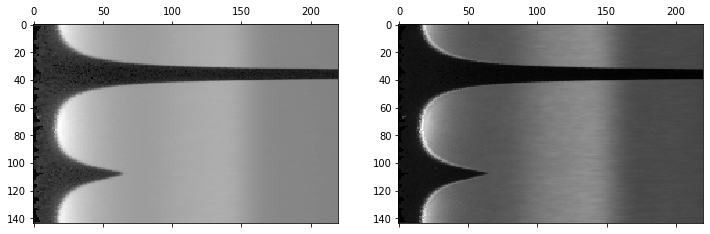

In [9]:
fig,((ax11,ax12)) = plt.subplots(1,2,figsize=(12,12))
ax11.matshow(polarCBEDmean**0.2)
ax12.matshow(polarCBED_var**0.2)
print(np.mean(polarCBEDmean))

In [10]:
pet2.Nr

220

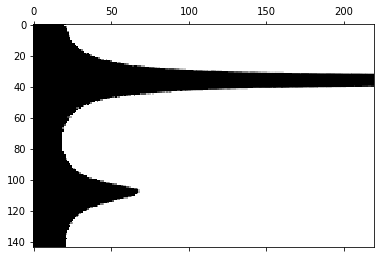

In [11]:
mask_ar = pet2.get_polar_transform_twoSided_gaussian(ar=full_mask,mask=full_mask,return_ans = True)
plt.matshow(mask_ar)

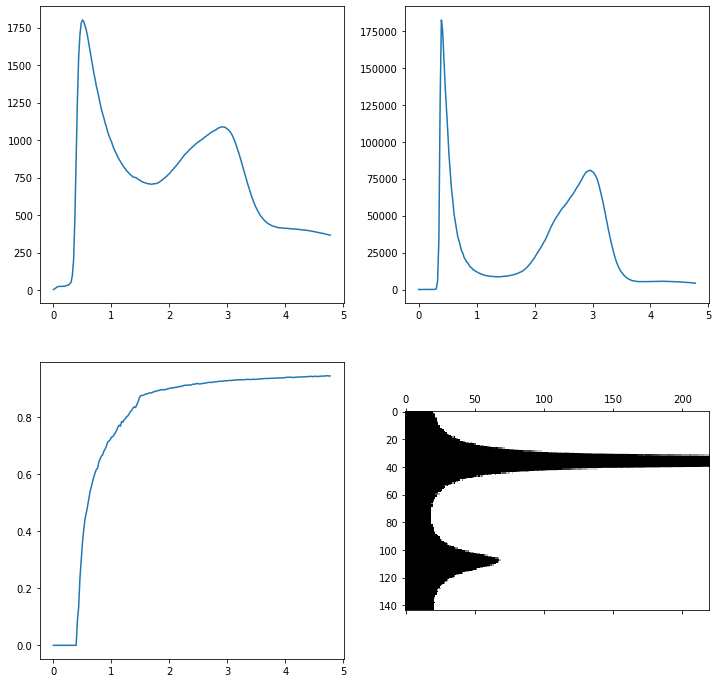

In [12]:
#mask_ar = pet2.get_polar_transform_twoSided_gaussian(ar=full_mask,return_ans = True)

polarCBED_var.shape
yMean = np.mean(polarCBEDmean,axis=0)
yVar = np.mean(polarCBED_var,axis=0)
yNorm = np.mean(mask_ar,axis=0)

pixelSize = 0.0218

fig1,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12,12))
ax1.plot(np.arange(polarCBED_var.shape[1])*pixelSize,yMean)
yMeanCopy = np.copy(yMean)
ax2.plot(np.arange(polarCBED_var.shape[1])*pixelSize,yVar)
ax3.plot(np.arange(polarCBED_var.shape[1])*pixelSize,yNorm)
ax4.matshow(mask_ar)
#print(mask_ar.shape)
#plt.matshow(full_mask)
sub = yNorm > 1e-1
yMean[sub] = yMean[sub] / yNorm[sub]
yVar[sub] = yVar[sub] / yNorm[sub]
yVar[np.logical_not(sub)] = 0

yy = yVar

sub = yMean > 0
yy[sub] = yVar[sub] / (yMean[sub]**2)


[4.31133112e+02 8.50627787e+03 2.62548055e+01 7.32510789e+02
 4.29473936e+01 1.44026768e+01 2.66375253e+02 2.87008174e+02
 7.27497206e-02 1.04809745e+00 1.40516789e+02]


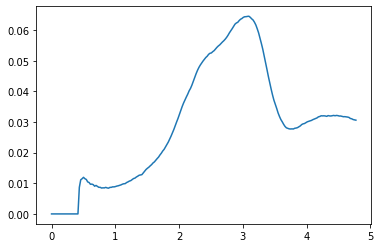

In [13]:
plt.plot(np.arange(yy.size)*pixelSize,yy)
print(pet2.coef_opt)
def fit_func(coef,r):
    term1 = coef[1] * np.exp( (-1/ (2*coef[2]**2)) * r**2)
    term2 = coef[3] * np.exp( (-1/ (2*coef[4]**2)) * (coef[10] - r)**2) * np.heaviside((coef[10] - r),0)
    term3 = coef[3] * np.exp( (-1/ (2*coef[5]**2)) * (coef[10] - r)**2) * np.heaviside((r - coef[10]),0)
    return coef[0]+term1+term2+term3

def fit_func_reduced(coef,r):
    term1 = coef[1] * np.exp( (-1/ (2*coef[2]**2)) * r**2)
    term2 = coef[3] * np.exp( (-1/ (2*coef[4]**2)) * (coef[10] - r)**2) * np.heaviside((coef[10] - r),0)
    term3 = coef[3] * np.exp( (-1/ (2*coef[5]**2)) * (coef[10] - r)**2) * np.heaviside((r - coef[10]),0)
    return term2+term3  

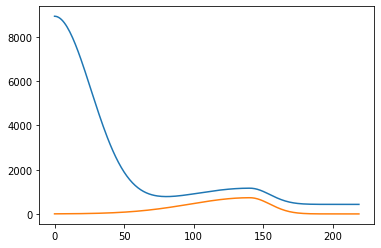

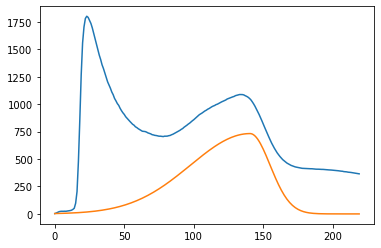

In [50]:
plt.plot(fit_func(pet2.coef_opt,np.arange(yy.size)))
plt.plot(fit_func_reduced(pet2.coef_opt,np.arange(yy.size)))

fig, ax = plt.subplots()
ax.plot(yMeanCopy)
ax.plot(fit_func_reduced(pet2.coef_opt,np.arange(yy.size)))